<a href="https://colab.research.google.com/github/Janasya85/Datasciences/blob/main/Turnover_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
print('Jsglp')

Jsglp


# PREPARATION

IMPORT LIBRARIES

In [20]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DataScienceClass')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

# modelling
import statsmodels.formula.api as smf
from scipy.special import expit, logit
from sklearn.preprocessing import LabelEncoder


sns.set_palette('muted')

FUNCTION

In [22]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from
    :return df: <pandas DataFrame>
    """
    coef = results.params
    std_err = results.bse

    df = pd.DataFrame(data = np.transpose([coef, std_err]),
                      index = coef.index,
                      columns=["coef","std err"])
    return df

In [23]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

DATA LOADING

In [25]:
df_turnover = pd.read_csv('turnover (1).csv')
df_turnover.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [27]:
df_turnover = df_turnover.rename(columns={
    'sales': 'department'})

In [29]:
front = df_turnover['left']
df_turnover.drop(labels=['left'], axis=1,inplace = True)
df_turnover.insert(0, 'left', front)
df_turnover.head(5)

,left,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


In [30]:
df_turnover.dtypes

,0
left,int64
satisfaction_level,float64
last_evaluation,float64
number_project,int64
average_montly_hours,int64
time_spend_company,int64
Work_accident,int64
promotion_last_5years,int64
department,object
salary,object


In [32]:
df_turnover.isnull().any()

,0
left,False
satisfaction_level,False
last_evaluation,False
number_project,False
average_montly_hours,False
time_spend_company,False
Work_accident,False
promotion_last_5years,False
department,False
salary,False


ANALYSIS

In [36]:
df_turnover.describe().T

,count,mean,std,min,25%,50%,75%,max
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


In [37]:
left_rate = df_turnover.left.value_counts() / len(df_turnover)
left_rate

,count
left,
0,0.761917
1,0.238083


As a baseline; there are 76% of employees stayed and 24% of employees left the company.

In [43]:
left_summary = df_turnover.groupby('left').mean(numeric_only=True)
left_summary.mean()

,0
satisfaction_level,0.553454
last_evaluation,0.716793
number_project,3.821083
average_montly_hours,203.239707
time_spend_company,3.628268
Work_accident,0.111167
promotion_last_5years,0.015786


<Axes: >

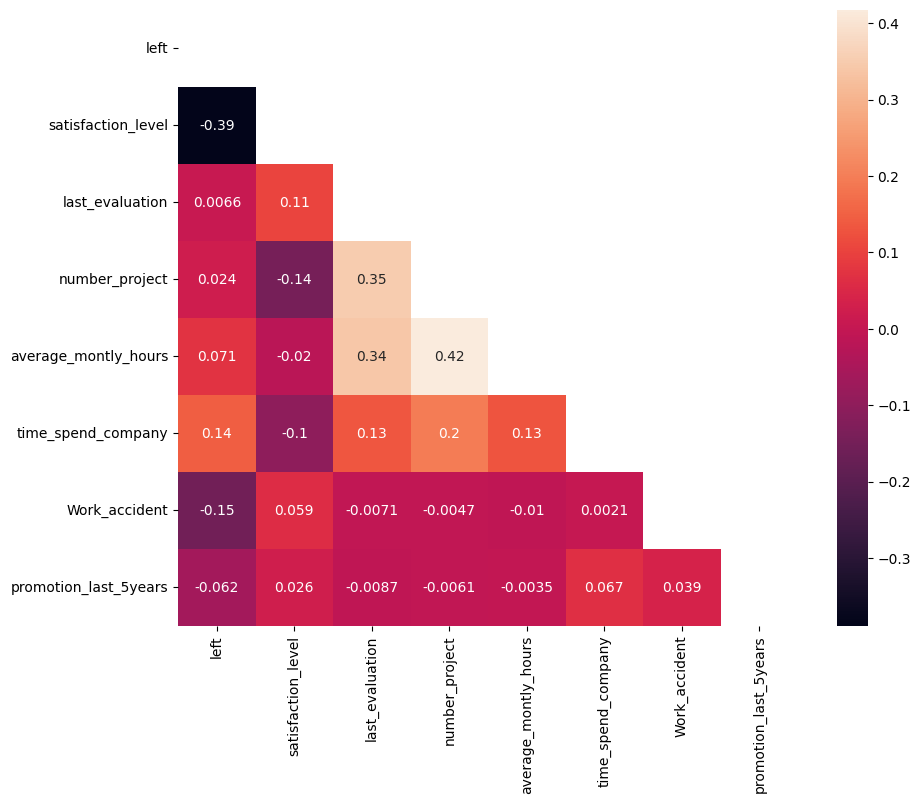

In [45]:
# correlation heatmap

# Filter only numeric columns for correlation
numeric_df = df_turnover.select_dtypes(include=['number'])

# Create the correlation matrix
corr = numeric_df.corr()

# Create the mask for the heatmap
mask = np.triu(np.ones_like(corr))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, mask=mask)

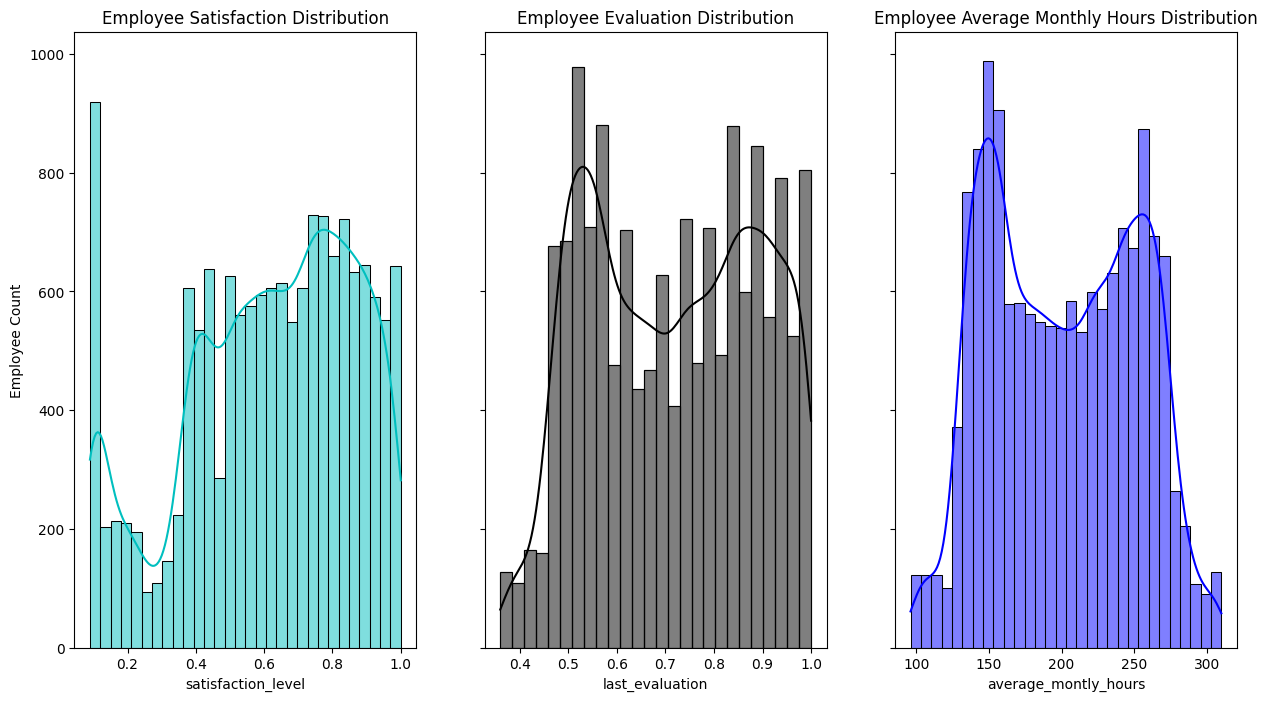

In [48]:
# Set up the matplotlib figure
fig, ax = plt.subplots(ncols=3, figsize=(15, 8), sharey=True)

# Graph Employee Satisfaction
sns.histplot(df_turnover.satisfaction_level, color='c', kde=True, ax=ax[0]).set_title('Employee Satisfaction Distribution')
ax[0].set_ylabel('Employee Count')

# Graph Employee Evaluation
sns.histplot(df_turnover.last_evaluation, color='k', kde=True, ax=ax[1]).set_title('Employee Evaluation Distribution')

# Graph Employee Average Monthly Hours
sns.histplot(df_turnover.average_montly_hours, color='b', kde=True, ax=ax[2]).set_title('Employee Average Monthly Hours Distribution')

plt.show()